# Difference in Difference (DID)

## DID Estimator

Difference in differences (DiD) is a tool to estimate treatment effects comparing the pre- and post-treatment differences in the outcome of a treatment and a control group. In general, we are interested in estimating the effect of a treatment Di (e.g. union status, medication, etc.) on an outcome Yi (e.g. wages, health, etc.) as in

$$Y_{it} = \alpha_i + \lambda_t + \rho D_{it} + X'_{it}\beta + \epsilon$$

where $\alpha_i$ are individual fixed effects (characteristics of individuals that do not change over time), $\lambda_t$ are time fixed effects, $X_{it}$ are time-varying covariates like individuals' age, and $\epsilon$ is an error term. Individuals and time are indexed by $i$ and $t$, respectively. If there is a correlation between the fixed effects and $D_{it}$ then estimating this regression via OLS will be biased given that the fixed effects are not controlled for. This is the typical omitted variable bias.

## The 2 X 2 DID

The 2X2 DD design has a **treatment** group $k$ and **untrated** (Control) group $U$. there is a pre-period for the treatment group, $pre(k)$; a post-period for the treatment group, $post(k)$; a pre-treatment period fo the control group, $pre(U)$; ad a post-perdio for the control group, $post(U)$

So:

$$
\widehat{\delta}^{2\times 2}_{kU} = \bigg ( \overline{y}_k^{-post(k)} - \overline{y}_k^{-pre(k)} \bigg ) - \bigg ( \overline{y}_U^{-post(k)} - \overline{y}_U^{-pre(k)} \bigg )
$$


where $\hat\delta_{kU}$ is the estimated ATT for group $k$, and $\tilde y$ is the sample mean for that particular group in a particular time period. The first paragraph differences the treatment group, $k$, after minus before, the second paragraph differences the control group, $U$, after minus before. And once those quantities are obtained, we difference the second term from the first.


Graphically this would look something like this:


![](figs/DID.png)

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

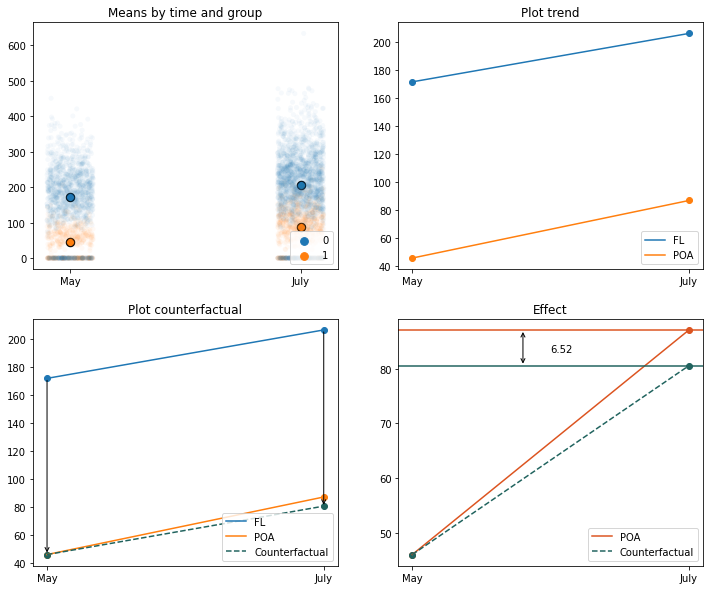

In [2]:
b_impact = pd.read_csv("https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/billboard_impact.csv")
b_impact.head()

poa_mean = b_impact[b_impact.poa == 1].groupby(["jul"]).mean()
no_poa_mean = b_impact[b_impact.poa == 0].groupby(["jul"]).mean()


import seaborn as sns
fz = 12
# Legend labesl
t_t = "POA"
c_c = "FL"
t_c = "Counterfactual"
# Legend color 

t_c_c = "#20635E"
t_t_c = "#DC5420"


fig, ax = plt.subplots(2, 2, figsize = (fz, fz - 2))

sns.stripplot(data = b_impact, x = "jul", y = "deposits", hue = "poa", alpha = .04, ax=ax[0, 0])

ax[0, 0].scatter(poa_mean.index, no_poa_mean.deposits, s = fz*6, color = "black")
ax[0, 0].scatter(poa_mean.index, poa_mean.deposits, s = fz*6, color = "black")
ax[0, 0].scatter(poa_mean.index, no_poa_mean.deposits, s = fz*3)
ax[0, 0].scatter(poa_mean.index, poa_mean.deposits, s = fz*3)
ax[0, 0].set_title("Means by time and group")
ax[0, 0].set_xlabel("")
ax[0, 0].set_ylabel("")


ax[0, 1].scatter(poa_mean.index, no_poa_mean.deposits)
ax[0, 1].plot(poa_mean.index, no_poa_mean.deposits, label = c_c)
ax[0, 1].scatter(poa_mean.index, poa_mean.deposits)
ax[0, 1].plot(poa_mean.index, poa_mean.deposits, label = t_t)
ax[0, 1].set_title("Plot trend")


par = no_poa_mean.unstack() - poa_mean.unstack()
new_poa = no_poa_mean.unstack() - par[0]
new_poa = pd.DataFrame(new_poa[:2], columns=["deposits"]) 

ax[1, 0].scatter(poa_mean.index, no_poa_mean.deposits)
ax[1, 0].plot(poa_mean.index, no_poa_mean.deposits, label = c_c)
ax[1, 0].scatter(poa_mean.index, poa_mean.deposits)
ax[1, 0].plot(poa_mean.index, poa_mean.deposits, label = t_t)
ax[1, 0].scatter(poa_mean.index, new_poa.deposits, color = t_c_c)
ax[1, 0].plot(poa_mean.index, new_poa.deposits, linestyle = "--", label = t_c, color = t_c_c)
ax[1, 0].annotate("", xy = (0, 171.64), xytext = (0, 46.01), 
            arrowprops=dict(arrowstyle="<-",
                            connectionstyle="arc3"))
ax[1, 0].annotate("", xy = (1, 206.16), xytext = (1, 80.06), 
            arrowprops=dict(arrowstyle="<-",
                            connectionstyle="arc3"))
ax[1, 0].set_title("Plot counterfactual")

eff = (poa_mean.unstack() - new_poa.unstack())
effect = round(eff.iloc[0, 1], 2)

ax[1, 1].scatter(poa_mean.index, poa_mean.deposits, color = t_t_c)
ax[1, 1].plot(poa_mean.index, poa_mean.deposits, label = t_t, color = t_t_c)
ax[1, 1].scatter(poa_mean.index, new_poa.deposits, color = t_c_c)
ax[1, 1].plot(poa_mean.index, new_poa.deposits, linestyle = "--", label = t_c, color = t_c_c)
ax[1, 1].axhline(87.06, color = t_t_c)
ax[1, 1].axhline(80.53, color = t_c_c)
ax[1, 1].annotate("", xy = (.4, 87.06), xytext = (.4, 80.53), 
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3"))
ax[1, 1].annotate(f"{effect}", xy = (.5, 83))
ax[1, 1].set_title("Effect")
# ax[1, 1].xlim(-.1, 1.1)

for i in range(2):
    for j in range(2):
        ax[i, j].legend(loc = "lower right")
        ax[i, j].set_xticks([0, 1])
        ax[i, j].set_xticklabels(["May", "July"])



In [3]:

# Estimate effect 

import statsmodels.formula.api as smf
smf.ols('deposits ~ poa*jul', data=b_impact).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,171.6423,2.363,72.625,0.000,167.009,176.276
poa,-125.6263,4.484,-28.015,0.000,-134.418,-116.835
jul,34.5232,3.036,11.372,0.000,28.571,40.475
poa:jul,6.5246,5.729,1.139,0.255,-4.706,17.755
